In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Set our RNG for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

In [74]:
from sklearn.datasets import load_iris

iris = load_iris()
X_raw = iris['data']
y_raw = iris['target']

In [75]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw)

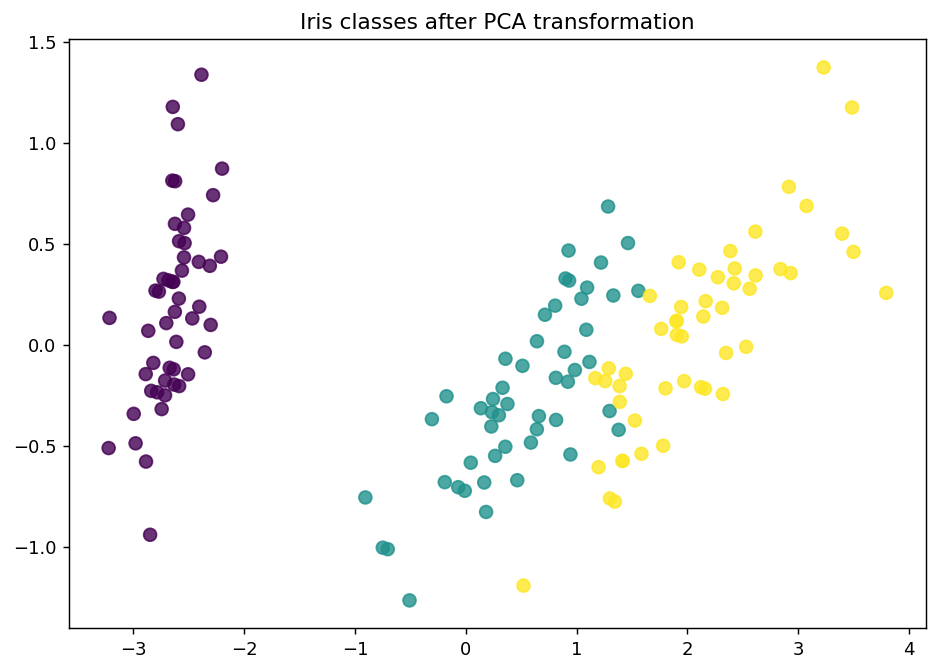

In [76]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_iris[:, 0], transformed_iris[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
plt.title('Iris classes after PCA transformation')
plt.show()

In [98]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_ = X_raw[training_indices]
X_train = {'al': X_, 'rnd': X_.copy()}
y_ = y_raw[training_indices]
y_train = {'al': y_, 'rnd': y_.copy()}

# Isolate the non-training examples we'll be querying.
X_ = np.delete(X_raw, training_indices, axis=0)
X_pool = {'al': X_, 'rnd': X_.copy()}

y_ = np.delete(y_raw, training_indices, axis=0)
y_pool = {'al': y_, 'rnd': y_.copy()}

In [99]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Specify our core estimator.
# knn 
lr = KNeighborsClassifier(n_neighbors=3)
# lr = LogisticRegression()

In [100]:
from functools import partial
from modAL.batch import uncertainty_batch_sampling
from modAL.models import ActiveLearner

# Pre-set our batch sampling to retrieve 3 samples at a time.
BATCH_SIZE = 3
preset_batch = partial(uncertainty_batch_sampling, n_instances=BATCH_SIZE)

# Specify our active learning model.
learner = ActiveLearner(
  estimator=lr, #knn,

  X_training=X_train['al'],
  y_training=y_train['al'],

  query_strategy=preset_batch
)

lr.fit(X_train['al'], y_train['al'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [101]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

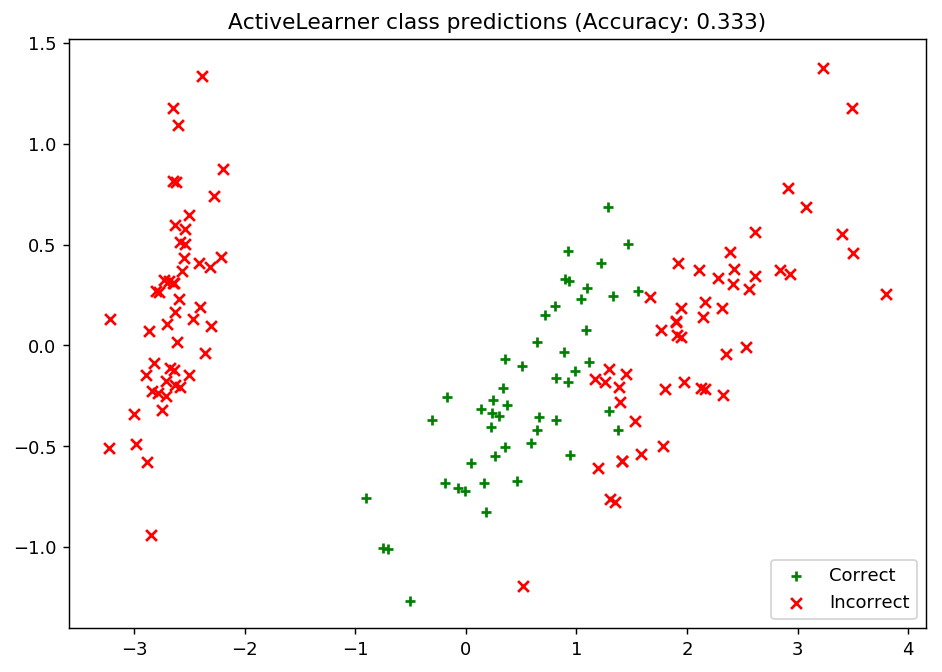

In [102]:
# Record our learner's score on the raw data.
# unqueried_score = learner.score(X_raw, y_raw)

lr_score = lr.score(X_raw, y_raw)

performance_history = {'al': [lr_score],
                       'rnd': [lr_score]}


# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct')
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect')
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=lr_score))
plt.show()

In [103]:
# Pool-based sampling
N_RAW_SAMPLES = 20
N_QUERIES = N_RAW_SAMPLES // BATCH_SIZE

for index in range(N_QUERIES):
    query_index, query_instance = learner.query(X_pool['al'])
    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool['al'][query_index], y_pool['al'][query_index]
    learner.teach(X=X, y=y)
    
    X_train['al'] = np.concatenate((X_train['al'], X))
    y_train['al'] = np.concatenate((y_train['al'], y))
    
    # Remove the queried instance from the unlabeled pool.
    X_pool['al'] = np.delete(X_pool['al'], query_index, axis=0)
    y_pool['al'] = np.delete(y_pool['al'], query_index)
    # Performance
    lr.fit(X=X_train['al'], y=y_train['al'])
    performance_history['al'].append(lr.score(X_raw, y_raw))
    
    query_index = np.random.randint(low=0, high=X_pool['rnd'].shape[0] + 1, size=BATCH_SIZE)
    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool['rnd'][query_index], y_pool['rnd'][query_index]
    
    X_train['rnd'] = np.concatenate((X_train['rnd'], X))
    y_train['rnd'] = np.concatenate((y_train['rnd'], y))
    
    # Remove the queried instance from the unlabeled pool.
    X_pool['rnd'] = np.delete(X_pool['rnd'], query_index, axis=0)
    y_pool['rnd'] = np.delete(y_pool['rnd'], query_index)
    # Performance
    lr.fit(X=X_train['rnd'], y=y_train['rnd'])
    performance_history['rnd'].append(lr.score(X_raw, y_raw))
    
    print(X_train['al'].shape)
    
    # Calculate and report our model's accuracy.
#     model_accuracy = learner.score(X_raw, y_raw)
#     print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    # Save our model's performance for plotting.
#     performance_history.append(model_accuracy)

(6, 4)
(9, 4)
(12, 4)
(15, 4)
(18, 4)
(21, 4)


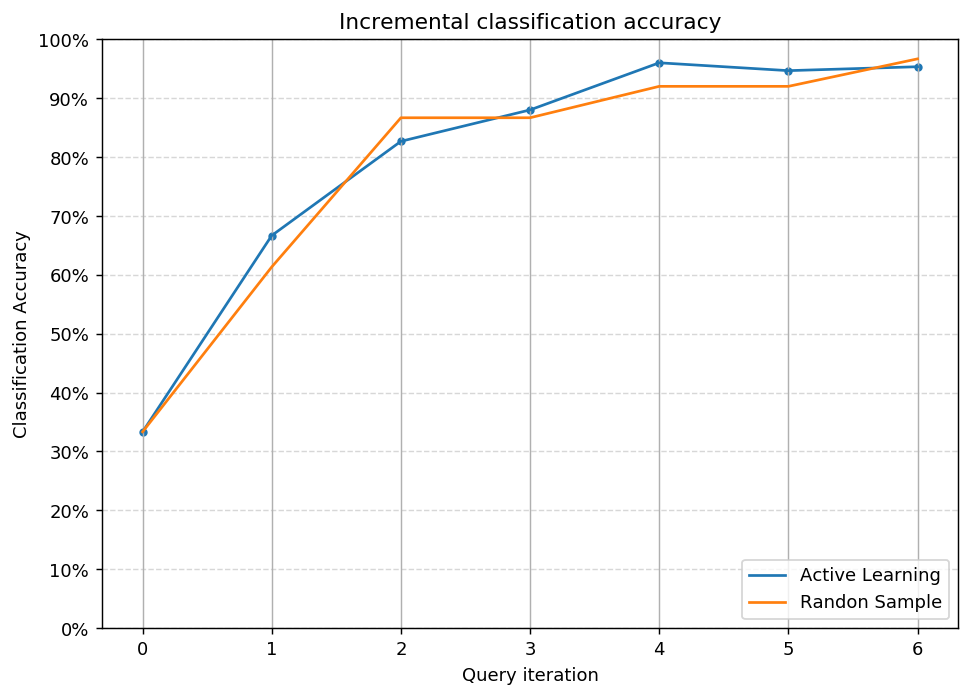

In [111]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history['al'], label='Active Learning')
ax.plot(performance_history['rnd'], label='Randon Sample')

ax.scatter(range(len(performance_history['al'])), performance_history['al'], s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=N_QUERIES + 3, integer=True))
ax.xaxis.grid(True)

ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
ax.set_ylim(bottom=0, top=1)
ax.yaxis.grid(True, linestyle='--', alpha=1/2)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

# Create another legend for the second line.
plt.legend(loc='lower right')

plt.show()

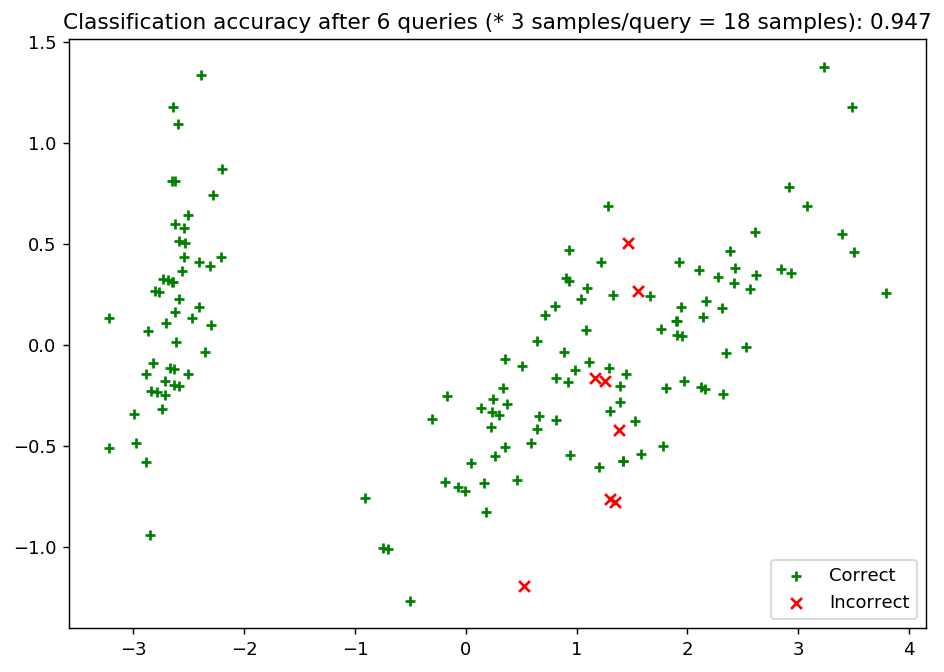

In [12]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct')
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect')

ax.set_title('Classification accuracy after {n} queries (* {batch_size} samples/query = {total} samples): {final_acc:.3f}'.format(
    n=N_QUERIES,
    batch_size=BATCH_SIZE,
    total=N_QUERIES * BATCH_SIZE,
    final_acc=performance_history[-1]
))
ax.legend(loc='lower right')

plt.show()